In [32]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [2]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


In [20]:
# vot_p

start_time = time.time()
print("Hi!")
end_time = time.time()
end_time - start_time

Hi!


0.0005540847778320312

# Travel time functions:

In [4]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

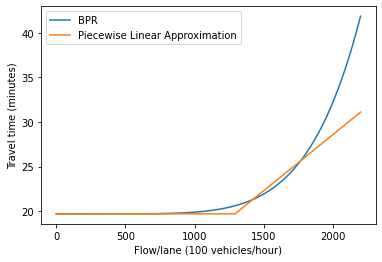

In [5]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Test Implementations (Naive):

In [6]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible = int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 44.4 $/hr; median: 36.6 $/hr


In [7]:
def OptPL_budget(tau, B, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
    users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val')
    edge_flows = m1.addVars(2, T, name = 'edge_flows')
    users_el = m1.addVars(3, T, name = 'eligible_allocation')
    
    # Add variables for piecewise affine approximation
    eps_flows = m1.addVars(2, T, name = 'eps_flows')

    ## Add constraints to Model 
    
    # Total edge flow, express lane:
    m1.addConstrs((edge_flows[0, t] == sum(users_in[i, 0, t] for i in range(num_ineligible)) + 
                  users_el[0, t] + sum(users_in[i, 1, t] for i in range(num_ineligible)) + 
                  users_el[1, t] for t in range(T)))
    # Total edge flow, general purpose lane:
    m1.addConstrs((edge_flows[1, t] == sum(users_in[i, 2, t] for i in range(num_ineligible)) + 
                  users_el[2, t] for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(3) for t in range(T)))
    m1.addConstrs((users_in[i, 0, t]==0 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for i in range(num_ineligible) for j in range(3) for t in range(T)))
    
    m1.addConstrs((sum(users_in[i, j, t] for j in range(3)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(3)) == 1 for i in range(num_ineligible) for t in range(T)))
     
    if tau != 0:
        m1.addConstr((sum(tau*users_el[0, t] for t in range(T)) <= B*num_eligible))
        
    # Add constraints for piecewise affine approximation
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity

    ### Frank: Unmodified below:
    
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2
                        +a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( tau*users_in[i,1,t]/vot_ineligible[i,t] for i in range(num_ineligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [8]:
### Frank: Unmodified below:

def _extract_solution(m):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 3, T))
    users_el = np.reshape(users_el, (3, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

# Sample Optimization Problem:

## Gurobi:

In [9]:
# # Trying to minimize f(x) = (x-2)^2 + 1 = x^2 - 4x + 5

# m_test = gp.Model()
# x = m_test.addVars(1, name = 'x')
# m_test.setObjective( x[0]**2 - 4*x[0] + 5, GRB.MINIMIZE)
# # m_test.update()
# m_test.optimize()


In [10]:
# m_test.getVars()[0].x

In [25]:
toll = 1.0
budget = 3.0
demand_multiplier = [25,75]

m_budget = OptPL_budget(toll, budget, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_budget.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 298831 rows, 99635 columns and 531260 nonzeros
Model fingerprint: 0x16ff6d3f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Presolve removed 298821 rows and 66420 columns
Presolve time: 0.22s
Presolved: 10 rows, 33215 columns, 66420 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.000e+00
 Factor NZ  : 1.500e+01 (roughly 13 MB of memory)
 Factor Ops : 2.500e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         P

In [27]:
# m_budget.getVars()
# solution_set = _extract_solution(m_budget)

m_budget.getVars()

[v.x for v in m_budget.getVars()]

# users_in = [v.x for v in m_budget.getVars() if v.VarName.find("ineligible_val") != -1]

# users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
# edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
# eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
# users_in = np.reshape(users_in, (num_ineligible, 3, T))
# users_el = np.reshape(users_el, (3, T))
# edge_flows = np.reshape(edge_flows, (2, T))
# eps_flows = np.reshape(eps_flows, (2, T))

# solution = {
#     "users_in": users_in,
#     "users_el": users_el,
#     "edge_flows": edge_flows,
#     "eps_flows": eps_flows
# }

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.2401857318877774e-11,
 1.1320722137497796e-11,
 1.3110512675496011e-11,
 1.0539902284278924e-11,
 1.297895124707793e-11,
 0.9999999999875981,
 0.9999999999886793,
 0.9999999999868895,
 0.9999999999894601,
 0.999999999987021,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.3546830324173698e-11,
 1.198063870333499e-11,
 1.0830447649823327e-11,
 1.242861369377124e-11,
 1.3562040379611062e-11,
 0.9999999999864532,
 0.9999999999880194,
 0.9999999999891696,
 0.9999999999875714,
 0.999999999986438,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.3465784043376061e-11,
 1.1007750266855965e-11,
 1.1713852110517564e-11,
 1.1179390746463014e-11,
 1.0767720048932006e-11,
 0.9999999999865342,
 0.9999999999889922,
 0.9999999999882861,
 0.9999999999888206,
 0.9999999999892323,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.2015832773215607e-11,
 1.1829981438893356e-11,
 1.139588423626492e-11,
 1.3585577107733116e-11,
 1.1234124741577034e-11,
 0.9999999999879842,
 0.99999999998817,
 0.9999999999886041,
 0.9999999

## CVXPY:

In [ ]:
# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print("x.value:", x.value)
print()
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print("constraints[0].dual_value:", constraints[0].dual_value)

# Scratch Work:

In [27]:
# 20*np.linspace(0, 1, 21)[0:]
np.linspace(tau_arr[0], tau_arr[-3]*T,19)

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.,
       65., 70., 75., 80., 85., 90.])